# RNN

Basic Tokenizer

In [40]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Load the data
df = pd.read_csv("C:/Yee Ann/NUS/DSA4266/TruthSeeker2023/Features_For_Traditional_ML_Techniques.csv")

# Remove columns with a single unique value
df = df.drop(columns=['Unnamed: 0', 'BinaryNumTarget'])
df = df.loc[:, df.nunique() > 1]
df = df.drop_duplicates()

# Convert boolean columns to 0 and 1
df['majority_target'] = df['majority_target'].astype(int)

# Tokenize the 'tweet' column
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(df['tweet'])

# Convert text to sequences
X_text = tokenizer.texts_to_sequences(df['tweet'])
word_index = tokenizer.word_index

# Pad sequences to ensure they are the same length
max_length = 100  # Set max length of sequences
X_text = pad_sequences(X_text, maxlen=max_length, padding='post', truncating='post')

# Separate and scale numerical features
numerical_features = df.select_dtypes(['int64', 'int32', 'float64']).columns.tolist()
numerical_features.remove('majority_target')
X_num = df[numerical_features].values

scaler = StandardScaler()
X_num_scaled = scaler.fit_transform(X_num)

# Combine text sequences and numerical features into one dataset
X_combined = np.hstack((X_text, X_num_scaled))

# Define the target variable
y = df['majority_target'].values

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.3, random_state=42)

# Define callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2)
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Build the RNN model
model = Sequential([
    Embedding(input_dim=len(word_index) + 1, output_dim=128, input_length=max_length),
    LSTM(128, return_sequences=True),
    Dropout(0.5),
    LSTM(64, return_sequences=False),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with callbacks
history = model.fit(
    X_train, y_train, epochs=10, batch_size=32, validation_split=0.2,
    callbacks=[reduce_lr, early_stopping]
)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy}')

# Predict on test data
y_pred = model.predict(X_test)
y_pred_use = (y_pred > 0.5).astype(int)

# Evaluate the model using accuracy
accuracy = accuracy_score(y_test, y_pred_use)
print(f"RNN Accuracy: {accuracy:.4f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_use, target_names=['Fake', 'Real']))

# Confusion Matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_use))

Epoch 1/10


c:\Users\laiye\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


2349/2349 ━━━━━━━━━━━━━━━━━━━━ 427s 181ms/step - accuracy: 0.5139 - loss: 0.6934 - val_accuracy: 0.5474 - val_loss: 0.6856 - learning_rate: 0.0010
Epoch 2/10
2349/2349 ━━━━━━━━━━━━━━━━━━━━ 446s 190ms/step - accuracy: 0.5350 - loss: 0.6901 - val_accuracy: 0.5672 - val_loss: 0.6798 - learning_rate: 0.0010
Epoch 3/10
2349/2349 ━━━━━━━━━━━━━━━━━━━━ 430s 183ms/step - accuracy: 0.5496 - loss: 0.6863 - val_accuracy: 0.5509 - val_loss: 0.6856 - learning_rate: 0.0010
Epoch 4/10
2349/2349 ━━━━━━━━━━━━━━━━━━━━ 439s 187ms/step - accuracy: 0.7110 - loss: 0.5514 - val_accuracy: 0.9161 - val_loss: 0.2709 - learning_rate: 0.0010
Epoch 5/10
2349/2349 ━━━━━━━━━━━━━━━━━━━━ 551s 235ms/step - accuracy: 0.9279 - loss: 0.2584 - val_accuracy: 0.9289 - val_loss: 0.2364 - learning_rate: 0.0010
Epoch 6/10
2349/2349 ━━━━━━━━━━━━━━━━━━━━ 544s 232ms/step - accuracy: 0.9386 - loss: 0.2344 - val_accuracy: 0.9327 - val_loss: 0.2306 - learning_rate: 0.0010
Epoch 7/10
2349/2349 ━━━━━━━━━━━━━━━━━━━━ 443s 189ms/step - acc

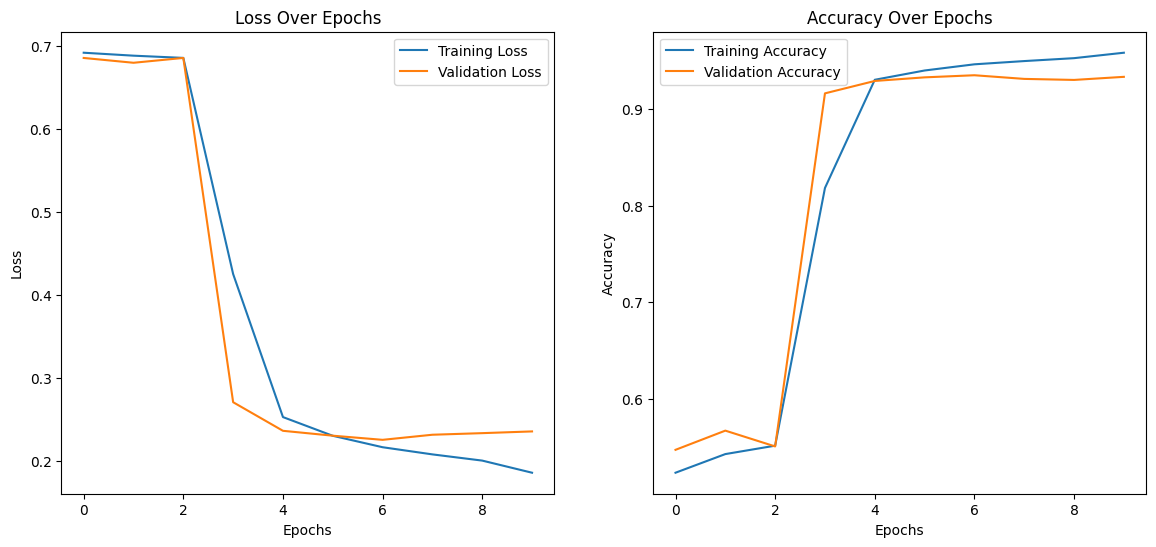

In [ ]:
import matplotlib.pyplot as plt

# Plotting training & validation loss
plt.figure(figsize=(14, 6))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Sentence Embeddings

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Concatenate, Reshape
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sentence_transformers import SentenceTransformer

with open("C:/Yee Ann/NUS/DSA4266/TruthSeeker2023/Features_For_Traditional_ML_Techniques.csv") as file:
    df = pd.read_csv(file)

#remove columns with single unique value
df = df.drop(columns = ['Unnamed: 0', 'BinaryNumTarget'])
df = df.loc[:, df.nunique() > 1]
df = df.drop_duplicates()

# Convert boolean columns to 0 and 1
df['majority_target'] = df['majority_target'].astype(int)

# Load pre-trained sentence transformer model
model_sbert = SentenceTransformer('all-MiniLM-L6-v2')

# Generate sentence embeddings for the 'tweet' column
X_tweet_embeddings = model_sbert.encode(df['tweet'].tolist(), convert_to_numpy=True)

numerical_features = df.select_dtypes(['int64', 'int32', 'float64']).columns.tolist()
numerical_features.remove('majority_target')
X_num = df[numerical_features].values

# Scale the numerical features
scaler = StandardScaler()
X_num_scaled = scaler.fit_transform(X_num)

# Pad sequences to ensure they are the same length
max_length = 100  # Set max length of sequences
X_text = pad_sequences(X_text, maxlen=max_length, padding='post', truncating='post')

# Separate the numerical features
numerical_features = df.select_dtypes(['int64', 'int32', 'float64']).columns.tolist()
numerical_features.remove('majority_target')
X_num = df[numerical_features].values

# Scale the numerical features
scaler = StandardScaler()
X_num_scaled = scaler.fit_transform(X_num)

# Define inputs for tweet embeddings and numerical features
input_tweet = Input(shape=(X_tweet_embeddings.shape[1],))  # Shape for precomputed embeddings
input_numerical = Input(shape=(X_num_scaled.shape[1],))

# Reshape embeddings to add timestep dimension for LSTM
reshaped_tweet = Reshape((1, X_tweet_embeddings.shape[1]))(input_tweet)  # Shape: (batch_size, 1, 384)

# Apply LSTM to tweet embeddings
lstm_tweet = LSTM(128, return_sequences=False)(reshaped_tweet)

# Combine LSTM output and numerical features
combined = Concatenate()([lstm_tweet, input_numerical])

# Dense layers for classification
x = Dense(64, activation='relu')(combined)
x = Dropout(0.5)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

# Define the model
model = Model(inputs=[input_tweet, input_numerical], outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


# Split data into training and test sets
X_train_tweet, X_test_tweet, X_train_num, X_test_num, y_train, y_test = train_test_split(
    X_tweet_embeddings, X_num_scaled, df['majority_target'], test_size=0.3, random_state=42)

# Callbacks for training
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2)
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Train the model
history = model.fit([X_train_tweet, X_train_num], y_train, epochs=10, batch_size=32, validation_split=0.2, callbacks=[early_stopping, reduce_lr])

# Evaluate the model
loss, accuracy = model.evaluate([X_test_tweet, X_test_num], y_test)
print(f'Test Accuracy: {accuracy}')

# Predict on test data
y_pred = model.predict([X_test_tweet, X_test_num])
y_pred_use = (y_pred > 0.5).astype(int)

# Evaluate the model using accuracy
accuracy = accuracy_score(y_test, y_pred_use)
print(f"RNN Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_use, target_names=['Fake', 'Real']))

# Confusion Matrix to understand predictions
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_use))

Epoch 1/10


c:\Users\laiye\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_137', 'keras_tensor_138']. Received: the structure of inputs=('*', '*')
  warnings.warn(


2349/2349 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.7325 - loss: 0.5457 - val_accuracy: 0.8396 - val_loss: 0.3936 - learning_rate: 0.0010
Epoch 2/10
2349/2349 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8437 - loss: 0.4032 - val_accuracy: 0.8745 - val_loss: 0.3363 - learning_rate: 0.0010
Epoch 3/10
2349/2349 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.8779 - loss: 0.3445 - val_accuracy: 0.8885 - val_loss: 0.3095 - learning_rate: 0.0010
Epoch 4/10
2349/2349 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8947 - loss: 0.3137 - val_accuracy: 0.8966 - val_loss: 0.2970 - learning_rate: 0.0010
Epoch 5/10
2349/2349 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9054 - loss: 0.2932 - val_accuracy: 0.8997 - val_loss: 0.2924 - learning_rate: 0.0010
Epoch 6/10
2349/2349 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9119 - loss: 0.2785 - val_accuracy: 0.9049 - val_loss: 0.2802 - learning_rate: 0.0010
Epoch 7/10
2349/2349 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9178 - loss: 0.2670

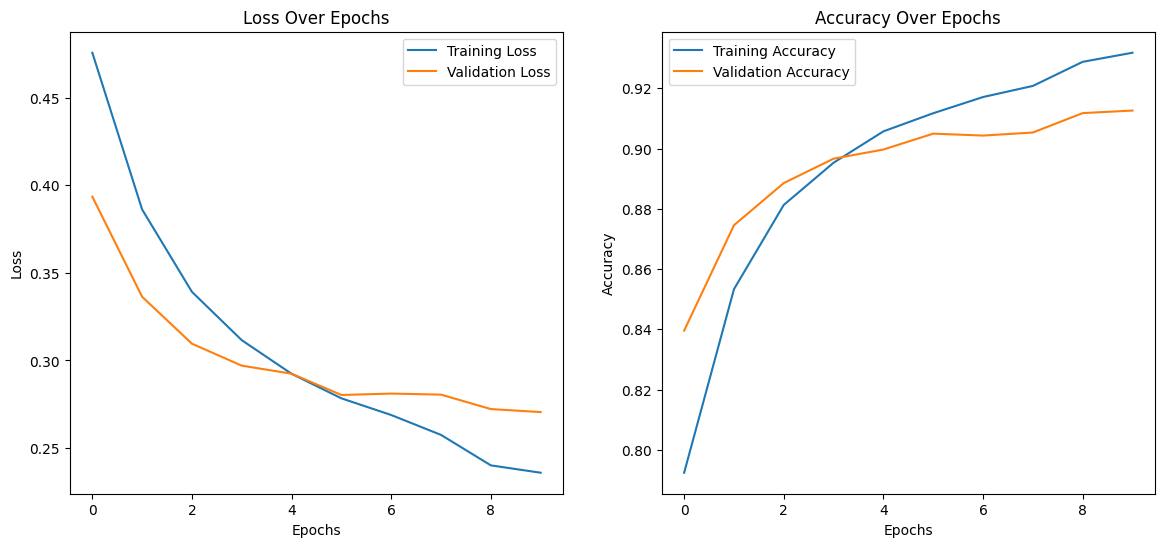

In [43]:
import matplotlib.pyplot as plt

# Plotting training & validation loss
plt.figure(figsize=(14, 6))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Sentence embeddings + BatchNormalization & regularizer

In [48]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Concatenate, Reshape, BatchNormalization
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.regularizers import l2
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sentence_transformers import SentenceTransformer

with open("C:/Yee Ann/NUS/DSA4266/TruthSeeker2023/Features_For_Traditional_ML_Techniques.csv") as file:
    df = pd.read_csv(file)

#remove columns with single unique value
df = df.drop(columns = ['Unnamed: 0', 'BinaryNumTarget'])
df = df.loc[:, df.nunique() > 1]
df = df.drop_duplicates()

# Convert boolean columns to 0 and 1
df['majority_target'] = df['majority_target'].astype(int)

# Load pre-trained sentence transformer model
model_sbert = SentenceTransformer('all-MiniLM-L6-v2')

# Generate sentence embeddings for the 'tweet' column
X_tweet_embeddings = model_sbert.encode(df['tweet'].tolist(), convert_to_numpy=True)

numerical_features = df.select_dtypes(['int64', 'int32', 'float64']).columns.tolist()
numerical_features.remove('majority_target')
X_num = df[numerical_features].values

# Scale the numerical features
scaler = StandardScaler()
X_num_scaled = scaler.fit_transform(X_num)

# Pad sequences to ensure they are the same length
max_length = 100  # Set max length of sequences
X_text = pad_sequences(X_text, maxlen=max_length, padding='post', truncating='post')

# Separate the numerical features
numerical_features = df.select_dtypes(['int64', 'int32', 'float64']).columns.tolist()
numerical_features.remove('majority_target')
X_num = df[numerical_features].values

# Scale the numerical features
scaler = StandardScaler()
X_num_scaled = scaler.fit_transform(X_num)

# Define inputs for tweet embeddings and numerical features
input_tweet = Input(shape=(X_tweet_embeddings.shape[1],))  # Shape for precomputed embeddings
input_numerical = Input(shape=(X_num_scaled.shape[1],))

# Reshape embeddings to add timestep dimension for LSTM
reshaped_tweet = Reshape((1, X_tweet_embeddings.shape[1]))(input_tweet)  # Shape: (batch_size, 1, 384)

# Apply LSTM to tweet embeddings
lstm_tweet = LSTM(128, return_sequences=False)(reshaped_tweet)

# Combine LSTM output and numerical features
combined = Concatenate()([lstm_tweet, input_numerical])

# Dense layers for classification
x = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(combined)
x = Dropout(0.5)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
output = Dense(1, activation='sigmoid')(x)

# Define the model
model = Model(inputs=[input_tweet, input_numerical], outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


# Split data into training and test sets
X_train_tweet, X_test_tweet, X_train_num, X_test_num, y_train, y_test = train_test_split(
    X_tweet_embeddings, X_num_scaled, df['majority_target'], test_size=0.3, random_state=42)

# Callbacks for training
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2)
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Train the model
history = model.fit([X_train_tweet, X_train_num], y_train, epochs=10, batch_size=32, validation_split=0.2, callbacks=[early_stopping, reduce_lr])

# Evaluate the model
loss, accuracy = model.evaluate([X_test_tweet, X_test_num], y_test)
print(f'Test Accuracy: {accuracy}')

# Predict on test data
y_pred = model.predict([X_test_tweet, X_test_num])
y_pred_use = (y_pred > 0.5).astype(int)

# Evaluate the model using accuracy
accuracy = accuracy_score(y_test, y_pred_use)
print(f"RNN Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_use, target_names=['Fake', 'Real']))

# Confusion Matrix to understand predictions
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_use))

Epoch 1/10


c:\Users\laiye\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_168', 'keras_tensor_169']. Received: the structure of inputs=('*', '*')
  warnings.warn(


2349/2349 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - accuracy: 0.6753 - loss: 0.8252 - val_accuracy: 0.8203 - val_loss: 0.4460 - learning_rate: 0.0010
Epoch 2/10
2349/2349 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.8214 - loss: 0.4603 - val_accuracy: 0.8449 - val_loss: 0.4090 - learning_rate: 0.0010
Epoch 3/10
2349/2349 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.8467 - loss: 0.4279 - val_accuracy: 0.8601 - val_loss: 0.3865 - learning_rate: 0.0010
Epoch 4/10
2349/2349 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8632 - loss: 0.3995 - val_accuracy: 0.8739 - val_loss: 0.3626 - learning_rate: 0.0010
Epoch 5/10
2349/2349 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8732 - loss: 0.3818 - val_accuracy: 0.8832 - val_loss: 0.3469 - learning_rate: 0.0010
Epoch 6/10
2349/2349 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8811 - loss: 0.3674 - val_accuracy: 0.8888 - val_loss: 0.3389 - learning_rate: 0.0010
Epoch 7/10
2349/2349 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8905 - loss: 0.35

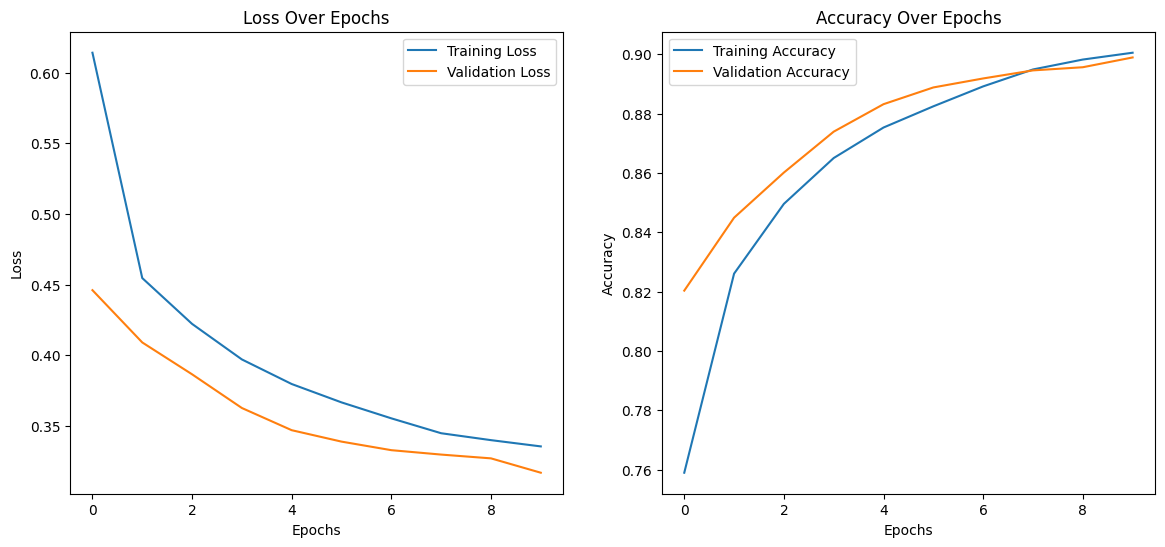

In [49]:
import matplotlib.pyplot as plt

# Plotting training & validation loss
plt.figure(figsize=(14, 6))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Bidirection RNN

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Concatenate, Reshape, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sentence_transformers import SentenceTransformer

with open("C:/Yee Ann/NUS/DSA4266/TruthSeeker2023/Features_For_Traditional_ML_Techniques.csv") as file:
    df = pd.read_csv(file)

#remove columns with single unique value
df = df.drop(columns = ['Unnamed: 0', 'BinaryNumTarget'])
df = df.loc[:, df.nunique() > 1]
df = df.drop_duplicates()

# Convert boolean columns to 0 and 1
df['majority_target'] = df['majority_target'].astype(int)

# Load pre-trained sentence transformer model
model_sbert = SentenceTransformer('all-MiniLM-L6-v2')

# Generate sentence embeddings for the 'tweet' column
X_tweet_embeddings = model_sbert.encode(df['tweet'].tolist(), convert_to_numpy=True)

numerical_features = df.select_dtypes(['int64', 'int32', 'float64']).columns.tolist()
numerical_features.remove('majority_target')
X_num = df[numerical_features].values

# Scale the numerical features
scaler = StandardScaler()
X_num_scaled = scaler.fit_transform(X_num)

# Pad sequences to ensure they are the same length
max_length = 100  # Set max length of sequences
X_text = pad_sequences(X_text, maxlen=max_length, padding='post', truncating='post')

# Separate the numerical features
numerical_features = df.select_dtypes(['int64', 'int32', 'float64']).columns.tolist()
numerical_features.remove('majority_target')
X_num = df[numerical_features].values

# Scale the numerical features
scaler = StandardScaler()
X_num_scaled = scaler.fit_transform(X_num)

# Define inputs for statement, tweet, and numerical features
input_tweet = Input(shape=(X_tweet_embeddings.shape[1],))
input_numerical = Input(shape=(X_num_scaled.shape[1],))

# Reshape to 3D for LSTM (adding a dimension for timesteps)
reshaped_tweet = Reshape((1, X_tweet_embeddings.shape[1]))(input_tweet)  # Shape: (batch_size, 1, 384)

# Bidirectional LSTM for tweet embeddings
bidirectional_lstm_tweet = Bidirectional(LSTM(128, return_sequences=False))(reshaped_tweet)

# Combine LSTM outputs and numerical features
combined = Concatenate()([bidirectional_lstm_tweet, input_numerical])

# Add dense layers
x = Dense(64, activation='relu')(combined)
x = Dropout(0.5)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

# Define the model
model = Model(inputs=[input_tweet, input_numerical], outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Split data into training and test sets
X_train_tweet, X_test_tweet, X_train_num, X_test_num, y_train, y_test = train_test_split(
    X_tweet_embeddings, X_num_scaled, df['majority_target'], test_size=0.3, random_state=42)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2)
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Train the model
history = model.fit([X_train_tweet, X_train_num], y_train, epochs=10, batch_size=32, validation_split=0.2, callbacks=[early_stopping, reduce_lr])

# Evaluate the model
loss, accuracy = model.evaluate([X_test_tweet, X_test_num], y_test)
print(f'Test Accuracy: {accuracy}')

# Predict on test data
y_pred = model.predict([X_test_tweet, X_test_num])

y_pred_use = (y_pred > 0.5).astype(int)
# Evaluate the model using accuracy
accuracy = accuracy_score(y_test, y_pred_use)
print(f"RNN Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_use, target_names=['Fake', 'Real']))

# Confusion Matrix to understand predictions
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_use))

Epoch 1/10


c:\Users\laiye\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_147', 'keras_tensor_148']. Received: the structure of inputs=('*', '*')
  warnings.warn(


2349/2349 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.7490 - loss: 0.5215 - val_accuracy: 0.8473 - val_loss: 0.3783 - learning_rate: 0.0010
Epoch 2/10
2349/2349 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.8578 - loss: 0.3797 - val_accuracy: 0.8801 - val_loss: 0.3241 - learning_rate: 0.0010
Epoch 3/10
2349/2349 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.8861 - loss: 0.3260 - val_accuracy: 0.8958 - val_loss: 0.2990 - learning_rate: 0.0010
Epoch 4/10
2349/2349 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.9019 - loss: 0.3016 - val_accuracy: 0.9025 - val_loss: 0.2872 - learning_rate: 0.0010
Epoch 5/10
2349/2349 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9084 - loss: 0.2836 - val_accuracy: 0.9069 - val_loss: 0.2789 - learning_rate: 0.0010
Epoch 6/10
2349/2349 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9161 - loss: 0.2641 - val_accuracy: 0.9090 - val_loss: 0.2754 - learning_rate: 0.0010
Epoch 7/10
2349/2349 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9210 - loss: 0.258

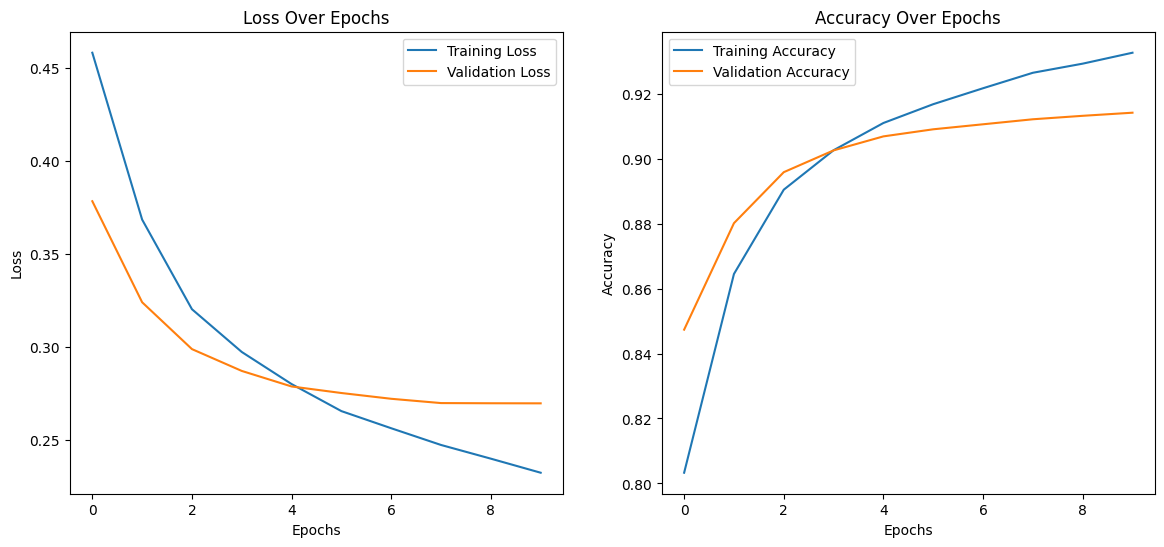

In [45]:
import matplotlib.pyplot as plt

# Plotting training & validation loss
plt.figure(figsize=(14, 6))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Bidirection RNN + BatchNormalization & regularizer

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Concatenate, Reshape, BatchNormalization, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.regularizers import l2
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sentence_transformers import SentenceTransformer

with open("C:/Yee Ann/NUS/DSA4266/TruthSeeker2023/Features_For_Traditional_ML_Techniques.csv") as file:
    df = pd.read_csv(file)

#remove columns with single unique value
df = df.drop(columns = ['Unnamed: 0', 'BinaryNumTarget'])
df = df.loc[:, df.nunique() > 1]
df = df.drop_duplicates()

# Convert boolean columns to 0 and 1
df['majority_target'] = df['majority_target'].astype(int)

# Load pre-trained sentence transformer model
model_sbert = SentenceTransformer('all-MiniLM-L6-v2')

# Generate sentence embeddings for the 'tweet' column
X_tweet_embeddings = model_sbert.encode(df['tweet'].tolist(), convert_to_numpy=True)

numerical_features = df.select_dtypes(['int64', 'int32', 'float64']).columns.tolist()
numerical_features.remove('majority_target')
X_num = df[numerical_features].values

# Scale the numerical features
scaler = StandardScaler()
X_num_scaled = scaler.fit_transform(X_num)

# Pad sequences to ensure they are the same length
max_length = 100  # Set max length of sequences
X_text = pad_sequences(X_text, maxlen=max_length, padding='post', truncating='post')

# Separate the numerical features
numerical_features = df.select_dtypes(['int64', 'int32', 'float64']).columns.tolist()
numerical_features.remove('majority_target')
X_num = df[numerical_features].values

# Scale the numerical features
scaler = StandardScaler()
X_num_scaled = scaler.fit_transform(X_num)

# Define inputs for statement, tweet, and numerical features
input_tweet = Input(shape=(X_tweet_embeddings.shape[1],))
input_numerical = Input(shape=(X_num_scaled.shape[1],))

# Reshape to 3D for LSTM (adding a dimension for timesteps)
reshaped_tweet = Reshape((1, X_tweet_embeddings.shape[1]))(input_tweet)  # Shape: (batch_size, 1, 384)

# Bidirectional LSTM for tweet embeddings
bidirectional_lstm_tweet = Bidirectional(LSTM(128, return_sequences=False))(reshaped_tweet)

# Combine LSTM outputs and numerical features
combined = Concatenate()([bidirectional_lstm_tweet, input_numerical])

# Add dense layers
x = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(combined)
x = Dropout(0.5)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
output = Dense(1, activation='sigmoid')(x)

# Define the model
model = Model(inputs=[input_tweet, input_numerical], outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Split data into training and test sets
X_train_tweet, X_test_tweet, X_train_num, X_test_num, y_train, y_test = train_test_split(
    X_tweet_embeddings, X_num_scaled, df['majority_target'], test_size=0.3, random_state=42)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2)
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Train the model
history = model.fit([X_train_tweet, X_train_num], y_train, epochs=10, batch_size=32, validation_split=0.2, callbacks=[early_stopping, reduce_lr])

# Evaluate the model
loss, accuracy = model.evaluate([X_test_tweet, X_test_num], y_test)
print(f'Test Accuracy: {accuracy}')

# Predict on test data
y_pred = model.predict([X_test_tweet, X_test_num])

y_pred_use = (y_pred > 0.5).astype(int)
# Evaluate the model using accuracy
accuracy = accuracy_score(y_test, y_pred_use)
print(f"RNN Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_use, target_names=['Fake', 'Real']))

# Confusion Matrix to understand predictions
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_use))

Epoch 1/10


c:\Users\laiye\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_157', 'keras_tensor_158']. Received: the structure of inputs=('*', '*')
  warnings.warn(


2349/2349 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6988 - loss: 0.7773 - val_accuracy: 0.8239 - val_loss: 0.4380 - learning_rate: 0.0010
Epoch 2/10
2349/2349 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8209 - loss: 0.4584 - val_accuracy: 0.8493 - val_loss: 0.4073 - learning_rate: 0.0010
Epoch 3/10
2349/2349 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.8505 - loss: 0.4215 - val_accuracy: 0.8686 - val_loss: 0.3750 - learning_rate: 0.0010
Epoch 4/10
2349/2349 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8694 - loss: 0.3916 - val_accuracy: 0.8788 - val_loss: 0.3609 - learning_rate: 0.0010
Epoch 5/10
2349/2349 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8787 - loss: 0.3724 - val_accuracy: 0.8881 - val_loss: 0.3409 - learning_rate: 0.0010
Epoch 6/10
2349/2349 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.8903 - loss: 0.3560 - val_accuracy: 0.8922 - val_loss: 0.3365 - learning_rate: 0.0010
Epoch 7/10
2349/2349 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8919 - loss: 0.349

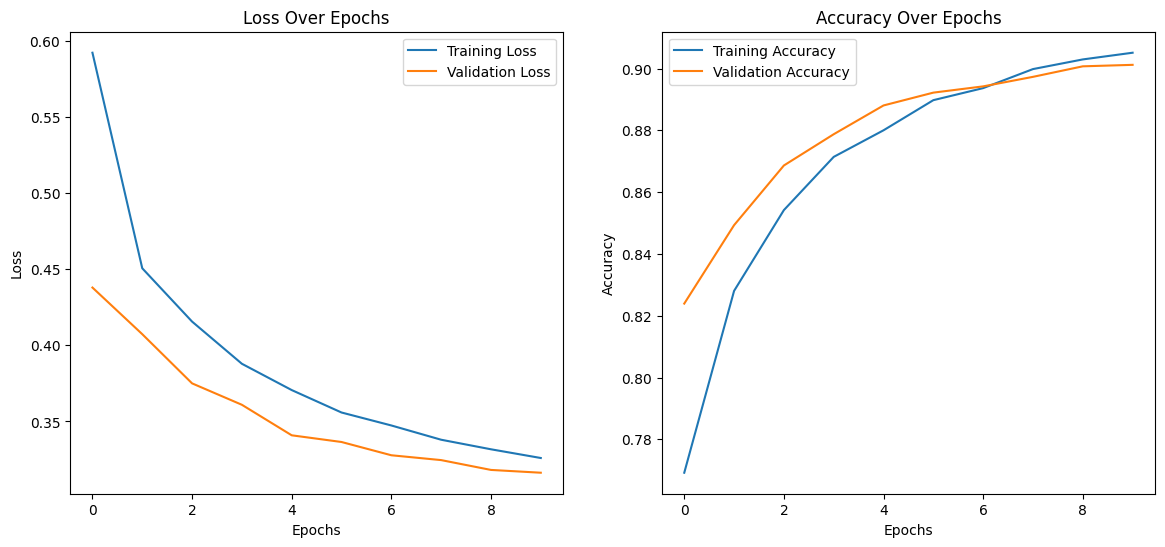

In [47]:
import matplotlib.pyplot as plt

# Plotting training & validation loss
plt.figure(figsize=(14, 6))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show() 